Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

##### To do: Take necessary actions to read the data

In [1]:
#Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import cv2
from glob import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from tensorflow.keras.regularizers import l2


from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

#### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
# Making sure the resize of images to the size img_height*img_width
input_shape = (img_height, img_width, 1)

In [9]:
# number of classes, epochs, seed
num_classes = 10
epochs = 20
seed_cnt = 123

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [13]:
# Using ImageDataGenerator to rescale the train_test & val datagen.
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
# creating sets for train, test & val using "flow_from_directory"
training_set = train_datagen.flow_from_directory(data_dir_train,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(data_dir_test,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(data_dir_train,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [15]:
#checking the clasess for below ds
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [16]:
# Checking the class indices for training_set
training_set.class_indices

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

In [17]:
# printing the shape sizes for all ds
train_y.shape,test_y.shape,val_y.shape

((2239,), (118,), (2239,))

####Visualize the data

create a code to visualize one instance of all the nine classes present in the dataset

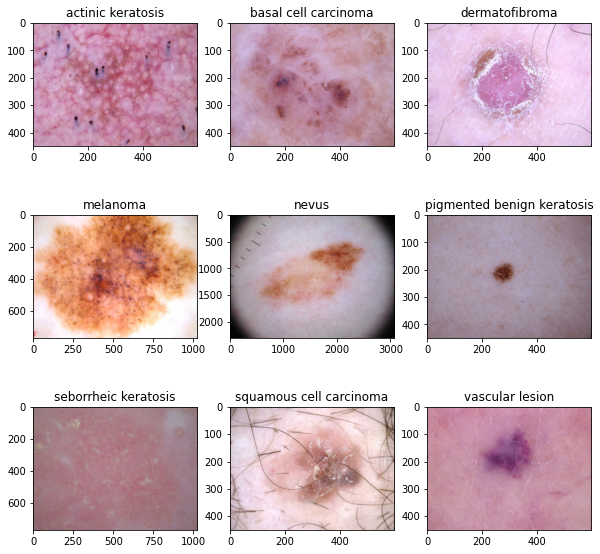

In [18]:
import matplotlib.pyplot as plt

### Code for training or validation data to visualize

import matplotlib.image as mpimg
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
    plt.title(class_names[i])
    plt.imshow(image)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

####Create the model

#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [20]:
# model architecture
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choosing an appropirate optimiser and loss function for model training 
from tensorflow.keras.optimizers import RMSprop

In [21]:
# importing optimizer from RMSprop
from tensorflow.keras.optimizers import RMSprop

In [22]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 28s 132ms/step - loss: 2.0522 - accuracy: 0.1953 - val_loss: 2.0499 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 4s 74ms/step - loss: 2.0223 - accuracy: 0.2042 - val_loss: 2.0131 - val_accuracy: 0.2371
Epoch 3/20
56/56 [==============================] - 4s 74ms/step - loss: 1.9748 - accuracy: 0.2360 - val_loss: 1.9863 - val_accuracy: 0.2215
Epoch 4/20
56/56 [==============================] - 4s 74ms/step - loss: 1.9525 - accuracy: 0.2494 - val_loss: 1.8968 - val_accuracy: 0.3087
Epoch 5/20
56/56 [==============================] - 4s 74ms/step - loss: 1.9514 - accuracy: 0.2539 - val_loss: 1.9442 - val_accuracy: 0.3356
Epoch 6/20
56/56 [==============================] - 4s 74ms/step - loss: 1.9448 - accuracy: 0.2550 - val_loss: 1.9275 - val_accuracy: 0.2349
Epoch 7/20
56/56 [==============================] - 4s 74ms/step - loss: 1.9429 - accuracy: 0.2852 - val_loss: 1.9880 - val_accuracy: 0.2036
Epoch 8/20


###Visualizing training results

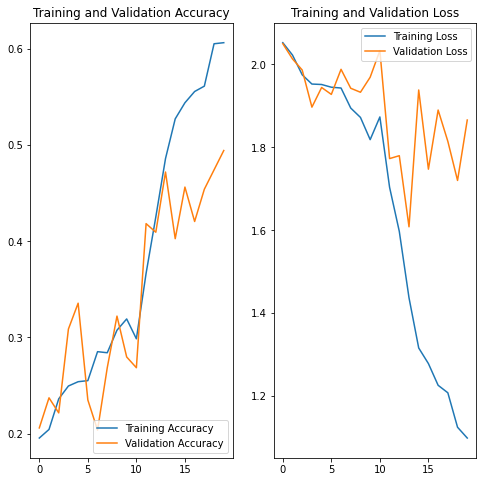

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# Lets store the final accuracy in a dataframe for the consecutive training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
accuracy_history_df = pd.DataFrame(data=[{"Type":"Vanilla","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.606585,0.494407,20


##### Findings after the model fit, if there is an evidence of model overfit or underfit

### Findings

First findings: The model seems to be overfitting as w.r.t loss, overfitting is calaculated, and the difference in loss functions in training & test around visible the 19-20th epoch

There is only accuracy around 60-65%, may be because, this network is too new (just 20 epochs), it was less time for learning.

In [27]:
# Ater you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

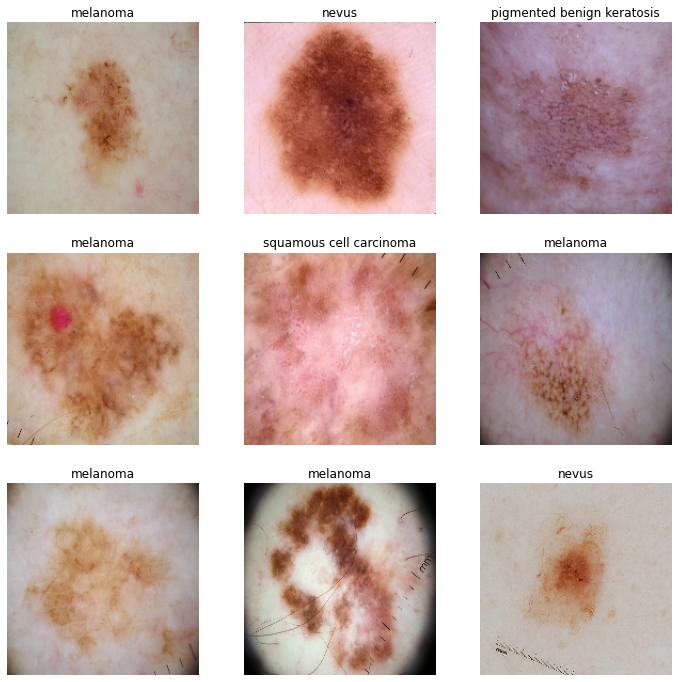

In [28]:
# Visualize augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images_aug, labels_aug in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images_aug)[i].numpy().astype("uint8"))
        plt.title(class_names[labels_aug[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [29]:
## Use Dropout layer if there is an evidence of overfitting in your findings

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [30]:
## Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [31]:
## Your code goes here, note: train your model for 20 epochs
epochs =20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 101ms/step - loss: 2.0716 - accuracy: 0.1825 - val_loss: 2.0307 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 6s 99ms/step - loss: 2.0228 - accuracy: 0.2143 - val_loss: 1.9850 - val_accuracy: 0.2908
Epoch 3/20
56/56 [==============================] - 5s 98ms/step - loss: 1.9978 - accuracy: 0.2773 - val_loss: 1.9248 - val_accuracy: 0.2013
Epoch 4/20
56/56 [==============================] - 5s 98ms/step - loss: 1.7791 - accuracy: 0.3465 - val_loss: 1.7702 - val_accuracy: 0.4027
Epoch 5/20
56/56 [==============================] - 5s 97ms/step - loss: 1.6400 - accuracy: 0.4196 - val_loss: 1.7099 - val_accuracy: 0.4206
Epoch 6/20
56/56 [==============================] - 5s 98ms/step - loss: 1.6101 - accuracy: 0.4252 - val_loss: 1.5098 - val_accuracy: 0.4653
Epoch 7/20
56/56 [==============================] - 5s 98ms/step - loss: 1.5447 - accuracy: 0.4542 - val_loss: 1.6418 - val_accuracy: 0.4318
Epoch 8/20
5

### Visualizing the results

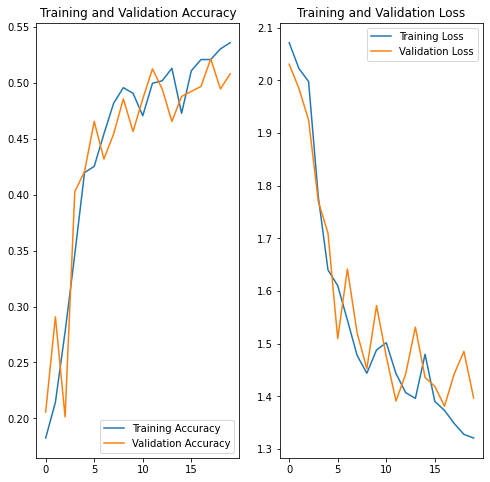

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit, see if there is an evidence of model overfit or underfit. 
Not seeing much improvements with respect to accuracy from the base model, but overfitting issue is slightly resolved because of data augmentation

With this 20 epochs not helping for final conclusion.

But some sort of improvement is visible now as compared to the previous model run.

### The distribution of classes in the training dataset.

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [33]:
# creating original_df to store & frame path & labels
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,vascular lesion
2235,/content/Skin cancer ISIC The International Sk...,vascular lesion
2236,/content/Skin cancer ISIC The International Sk...,vascular lesion
2237,/content/Skin cancer ISIC The International Sk...,vascular lesion


<BarContainer object of 9 artists>

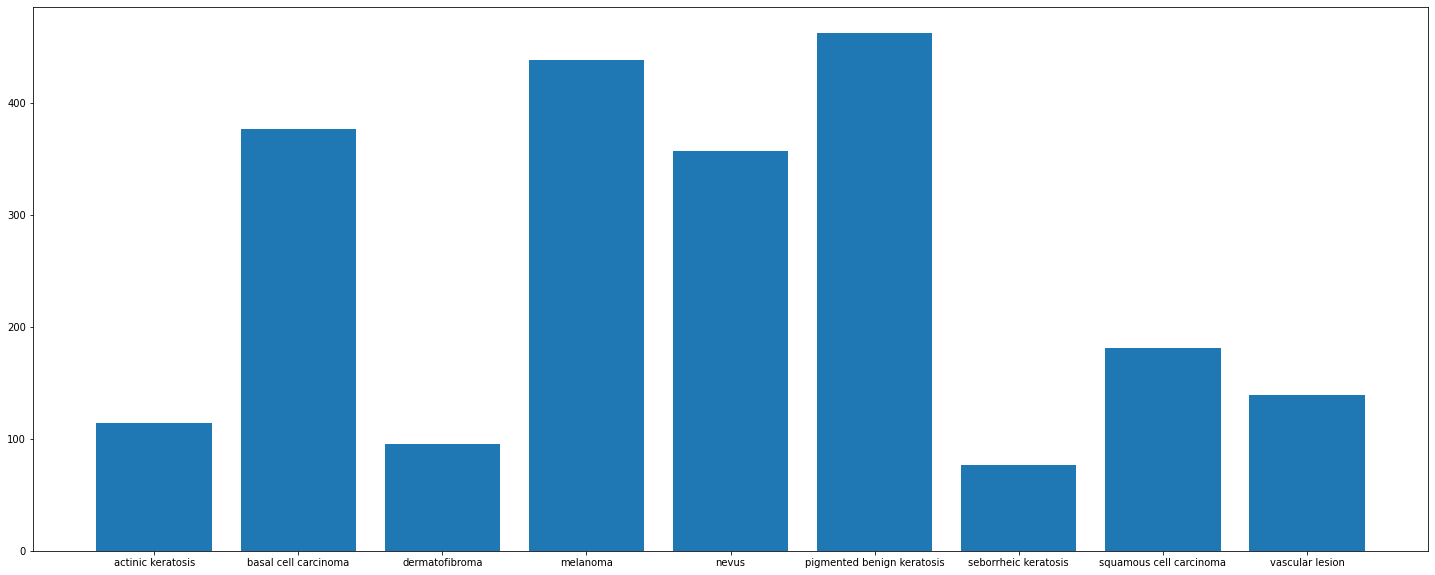

In [34]:
# Plotting BAR Chart with the distribution of all types of Skin Cancer
class_count=[]

for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

## findings Based on above Bar Chart visualization 
### - Seborrheic keratosis has least number of samples
### - pigmented benign keratosis(462) and melanoma(438) classs dominate the data in terms proportionate number of samples

## Rectifing the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [35]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [36]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse
    

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA1ECEEA7C0>: 100%|██████████| 500/500 [00:20<00:00, 23.93 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA1ECEFDBE0>: 100%|██████████| 500/500 [00:22<00:00, 22.49 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA1ED20DA90>: 100%|██████████| 500/500 [00:18<00:00, 26.70 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA1EC63C9A0>: 100%|██████████| 500/500 [01:28<00:00,  5.64 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FA1EC65D5E0>: 100%|██████████| 500/500 [01:21<00:00,  6.14 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA2401F4CA0>: 100%|██████████| 500/500 [00:17<00:00, 29.08 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA1ED15EF10>: 100%|██████████| 500/500 [00:45<00:00, 11.08 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA1ECF1DA60>: 100%|██████████| 500/500 [00:17<00:00, 28.86 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA266EC19D0>: 100%|██████████| 500/500 [00:17<00:00, 29.15 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.


In [38]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010900.jpg_0da98fbf-7508-4795-a85b-48b8cc54a02d.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011130.jpg_9eefdc60-d8a4-4efc-9b5c-13dfa7e6785a.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011130.jpg_5123d6f5-c23f-4618-84c3-758a74ce3d6b.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011174.jpg_53d2d7b4-a0e2-4c5f-ba86-9be8ea5ce64c.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010872.jpg_27e01d91-30f9-40ac-ace5-b8d91ca07f42.jpg',
 '/content/Skin

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [40]:
path_list_new = path_list
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [42]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [44]:
data_dir_train=path_to_training_dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####  Create a validation dataset


In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Create your model (make sure to include normalization)


In [46]:
## Creating model
num_classes = 9
normalization_layer = layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height,img_width,3))
model = Sequential([
    normalization_layer,
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='Same',
                 activation ='relu',input_shape= (180,180,32)),
    layers.BatchNormalization(),
    layers.Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
    layers.Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
    layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(512,kernel_regularizer=l2(0.001)),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes,activation ='softmax')
])


##### print model summary

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 90, 90, 32)       

#### Compile your model (Choose optimizer and loss function appropriately)

In [48]:
## Compiling model with optimizer = adam & loss function is sparse_categorical_crossentropy
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

####  Train your model

In [49]:
epochs = 30
## With Epochs = 30, training the model
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 42s 232ms/step - loss: 3.1251 - accuracy: 0.3049 - val_loss: 6.5713 - val_accuracy: 0.0831
Epoch 2/30
169/169 [==============================] - 29s 166ms/step - loss: 2.1943 - accuracy: 0.4269 - val_loss: 3.8611 - val_accuracy: 0.2138
Epoch 3/30
169/169 [==============================] - 30s 172ms/step - loss: 1.9583 - accuracy: 0.4596 - val_loss: 2.8697 - val_accuracy: 0.3311
Epoch 4/30
169/169 [==============================] - 29s 167ms/step - loss: 1.7912 - accuracy: 0.4981 - val_loss: 1.7670 - val_accuracy: 0.5241
Epoch 5/30
169/169 [==============================] - 29s 168ms/step - loss: 1.6559 - accuracy: 0.5508 - val_loss: 1.9171 - val_accuracy: 0.4595
Epoch 6/30
169/169 [==============================] - 32s 183ms/step - loss: 1.6049 - accuracy: 0.5729 - val_loss: 2.3799 - val_accuracy: 0.4499
Epoch 7/30
169/169 [==============================] - 29s 168ms/step - loss: 1.5908 - accuracy: 0.5961 - val_loss: 1.8442 - val_ac

###### Visualize the model results

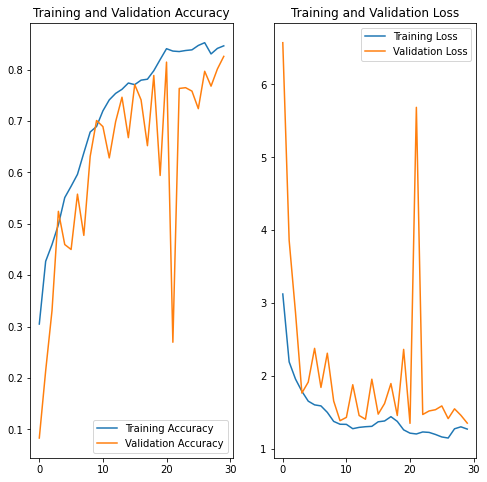

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

With the Epoch, seeing much improvements with respect to accuracy ~85% in train accuracy & ~82% in validation accuracy from the base model and overfitting issue is resolved because of data augmentation
There is some sort of improvement is visible now as compared to the previous model run, with class rebalance.